# Perform deconvolution to obtain building IRF

## Load libraries

In [1]:
from multitaper import MTCross
import multitaper.utils as utils
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

## Load building data

In [2]:
data = utils.get_data('crisanto_mesetas.dat')
dt   = 1/200.
npts,ntr = np.shape(data)

print('npts, # of traces, dt ',npts, ntr, dt)

npts, # of traces, dt  360001 5 0.005


## Plot time series

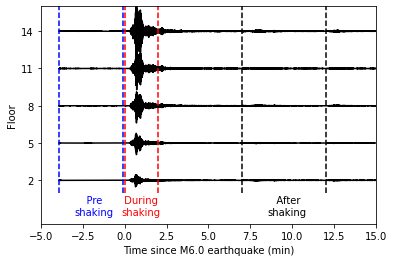

In [3]:
# create time vector
qtime = 3*60+55   # in seconds
t    = np.arange(npts)*dt - qtime
dmax = np.amax(data)/2

#-------------------------------------
# Define windows for deconvolution
#-------------------------------------
ta_1 = -3.9*60
ta_2 = -0.1*60
tb_1 = 0*60
tb_2 = 2*60
tc_1 = 7*60
tc_2 = 12*60
iloc1 = np.where((t>=ta_1) & (t<=ta_2))[0]
iloc2 = np.where((t>=tb_1) & (t<=tb_2))[0]
iloc3 = np.where((t>=tc_1) & (t<=tc_2))[0]

fig = plt.figure()
ax  = fig.add_subplot()
for i in range(ntr):
    ax.plot(t/60,data[:,i]/dmax+(i*3)+2,'k')
ax.set_xlabel('Time since M6.0 earthquake (min)')
ax.set_ylabel('Floor')
ax.set_yticks([2, 5, 8, 11, 14]);
ax.plot((ta_1/60,ta_1/60),(1,16),'b--')
ax.plot((ta_2/60,ta_2/60),(1,16),'b--')
ax.plot((tb_1/60,tb_1/60),(1,16),'r--')
ax.plot((tb_2/60,tb_2/60),(1,16),'r--')
ax.plot((tc_1/60,tc_1/60),(1,16),'k--')
ax.plot((tc_2/60,tc_2/60),(1,16),'k--')
ax.set_xlim(-5, 15)
ax.set_ylim(-1.5,16)
ax.text(-3.0,-0.8,'    Pre \nshaking',color='b')
ax.text(-0.2,-0.8,' During\nshaking',color='r')
ax.text(+8.5,-0.8,'   After\nshaking',color='k')
plt.savefig('figures/irf_waveforms.jpg')

In [4]:
def cross_2d(data,i0,dt,nw,kspec,fmin,fmax,tmin,tmax):

    fnyq = 0.5/dt
    wn   = [fmin/fnyq,fmax/fnyq]
    b, a = signal.butter(4, wn,'bandpass')

    ntr = np.shape(data)[1] 
    x   = data[:,i0]
    for i in range(ntr):
        y = data[:,i]
        Pxy  = MTCross(y,x,nw,kspec,dt)
        xcorr, dcohe, dconv  = Pxy.mt_corr()
        dconv = signal.filtfilt(b, a, dcohe[:,0])
        if (i==0):
            k    = np.linspace(-Pxy.npts,Pxy.npts,len(xcorr),dtype=int)
            t2   = k*dt
            tloc = np.where((t2>=-2.0) & (t2<=2))[0]
            irf  = np.zeros((len(tloc),ntr))
        irf[:,i] = dconv[tloc]
        t        = t2[tloc]

    return [irf,t]

In [5]:

#------------------------------------------------
# Define desired parameters
#------------------------------------------------
nw      = 3.5
kspec   = 5 
ifloor1 = 0
fmin    = 0.5
fmax    = 10.0
tmin    = -2.0
tmax    = +2.0

irf1,tirf = cross_2d(data[iloc1,:],ifloor1,dt,nw,kspec,
               fmin,fmax,tmin,tmax)

irf2,tirf = cross_2d(data[iloc2,:],ifloor1,dt,nw,kspec,
               fmin,fmax,tmin,tmax)

irf3,tirf = cross_2d(data[iloc3,:],ifloor1,dt,nw,kspec,
               fmin,fmax,tmin,tmax)



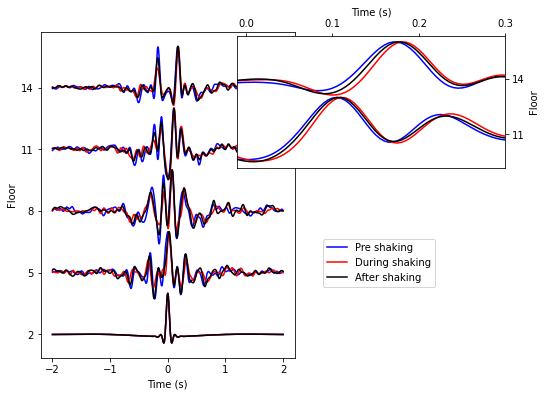

In [6]:
ntr = np.shape(data)[1] 

fig = plt.figure(figsize=(10,6))
ax  = fig.add_subplot(1,2,1)
for i in range(ntr):
    ax.plot(tirf,2*irf1[:,i]/np.max(irf1[:,i])+(i*3)+2,'b')
    ax.plot(tirf,2*irf2[:,i]/np.max(irf2[:,i])+(i*3)+2,'r')
    ax.plot(tirf,2*irf3[:,i]/np.max(irf3[:,i])+(i*3)+2,'k')
ax.set_yticks([2, 5, 8, 11, 14]);
ax.set_ylabel('Floor')
ax.set_xlabel('Time (s)')

ax2    = fig.add_subplot(1,2,2)
box    = ax2.get_position()
box.x0 = box.x0 -0.15
box.x1 = box.x1 -0.13
box.y0 = box.y0 + 0.44
box.y1 = box.y1 - 0.01
ax2.set_position(box)
for i in range(3,ntr):
    if (i==3):
        ax2.plot(tirf,2*irf1[:,i]/np.max(irf1[:,i])+(i*3)+2,'b',
             label='Pre shaking')
        ax2.plot(tirf,2*irf2[:,i]/np.max(irf2[:,i])+(i*3)+2,'r',
            label='During shaking')
        ax2.plot(tirf,2*irf3[:,i]/np.max(irf3[:,i])+(i*3)+2,'k',
            label='After shaking')
    else:
        ax2.plot(tirf,2*irf1[:,i]/np.max(irf1[:,i])+(i*3)+2,'b')
        ax2.plot(tirf,2*irf2[:,i]/np.max(irf2[:,i])+(i*3)+2,'r')
        ax2.plot(tirf,2*irf3[:,i]/np.max(irf3[:,i])+(i*3)+2,'k')

ax2.set_xlim(-0.01,0.3)
ax2.set_yticks([11, 14]);
ax2.set_xticks([0.0, 0.1, 0.2,0.3]);
ax2.set_ylabel('Floor')
ax2.set_xlabel('Time (s)')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.xaxis.set_label_position("top")
ax2.legend(bbox_to_anchor=(0.3,-0.5), loc="upper left")
plt.savefig('figures/irf_compare.jpg')
plt.show()
